In [ ]:
!pip install wandb torchvision matplotlib seaborn tensorboard scikit-learn opencv-python grad-cam


In [ ]:
import torch
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# download dataset

import kagglehub

# Download latest version
path = kagglehub.dataset_download("smaranjitghose/corn-or-maize-leaf-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/corn-or-maize-leaf-disease-dataset


In [ ]:
# list classes in the dataset

import os

classes = os.listdir(f'{path}/data')
print("Classes:", classes)


Classes: ['Common_Rust', 'Blight', 'Healthy', 'Gray_Leaf_Spot']


Preprocessing


*   resize pictures to a 224 by 224 pixels
*   convert pictures to tensors
*   normalize pictures using imagenet mean and standard deviation values
*   augment the training data with random horizontal flips brightness/contrast adjustments, and random crops



In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

# Normalize using ImageNet stats
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])




Split dataset into train, val and test
Effect data loaders

In [40]:
# Split dataset into train, val, and test
dataset = ImageFolder(f'{path}/data')
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.2, stratify=dataset.targets)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=[dataset.targets[i] for i in test_idx])

from torch.utils.data import Subset
train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

train_data.dataset.transform = train_transforms
val_data.dataset.transform = val_test_transforms
test_data.dataset.transform = val_test_transforms

# Data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

Modify the model to output the available classes of the dataset

In [42]:
import torch.nn as nn
from torchvision.models import alexnet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(dataset.classes))
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training setup using Weights and Biases (WandB) and TensorBoard

In [50]:
import wandb
wandb.init(project="maize-leaf-disease")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

Train Accuracy,▁▅▇██
Train Loss,█▄▂▁▁
Val Accuracy,▁▄█▁▅
Val Loss,▃▂▁█▄
Train Accuracy,0.98896
Train Loss,0.0329
Val Accuracy,0.9284
Val Loss,0.23955


Training and validation of modified model

In [45]:
for epoch in range(5):
    model.train()
    total, correct, running_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total
    wandb.log({"Train Loss": running_loss/len(train_loader), "Train Accuracy": train_acc})
    print("Train/Loss", running_loss/len(train_loader), 'Epoch:', epoch)
    print("Train/Accuracy:", train_acc, 'Epoch:', epoch)
    writer.add_scalar("Train/Loss", running_loss/len(train_loader), epoch)
    writer.add_scalar("Train/Accuracy", train_acc, epoch)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / val_total
    wandb.log({"Val Loss": val_loss/len(val_loader), "Val Accuracy": val_acc})
    print("Val/Loss:", val_loss/len(val_loader), 'Epoch:', epoch)
    print("Val/Accuracy:", val_acc, 'Epoch:', epoch)
    writer.add_scalar("Val/Loss", val_loss/len(val_loader), epoch)
    writer.add_scalar("Val/Accuracy", val_acc, epoch)
    print('')

Train/Loss 0.26902657662119184 Epoch: 0
Train/Accuracy: 0.8883582089552239 Epoch: 0
Val/Loss: 0.21979380079678126 Epoch: 0
Val/Accuracy: 0.9093078758949881 Epoch: 0

Train/Loss 0.12208894855741943 Epoch: 1
Train/Accuracy: 0.9519402985074626 Epoch: 1
Val/Loss: 0.20024787501565047 Epoch: 1
Val/Accuracy: 0.9236276849642004 Epoch: 1

Train/Loss 0.07467577216780878 Epoch: 2
Train/Accuracy: 0.9734328358208956 Epoch: 2
Val/Loss: 0.18223589499081885 Epoch: 2
Val/Accuracy: 0.9403341288782816 Epoch: 2

Train/Loss 0.038571113974432504 Epoch: 3
Train/Accuracy: 0.9871641791044776 Epoch: 3
Val/Loss: 0.3245134082223688 Epoch: 3
Val/Accuracy: 0.9093078758949881 Epoch: 3

Train/Loss 0.03290299580943871 Epoch: 4
Train/Accuracy: 0.988955223880597 Epoch: 4
Val/Loss: 0.23955188465437718 Epoch: 4
Val/Accuracy: 0.9284009546539379 Epoch: 4



Model Evaluation

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

model.eval()
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=dataset.classes))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

                precision    recall  f1-score   support

        Blight       0.91      0.93      0.92       115
   Common_Rust       1.00      0.98      0.99       130
Gray_Leaf_Spot       0.84      0.84      0.84        58
       Healthy       0.99      1.00      1.00       116

      accuracy                           0.95       419
     macro avg       0.94      0.94      0.94       419
  weighted avg       0.95      0.95      0.95       419

Confusion Matrix:
 [[107   0   8   0]
 [  1 127   1   1]
 [  9   0  49   0]
 [  0   0   0 116]]


GRAD CAM

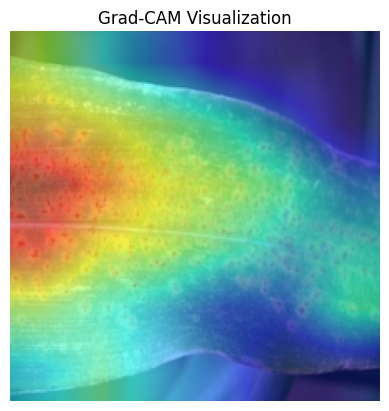

In [47]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

target_layer = model.features[-1]
cam = GradCAM(model=model, target_layers=[target_layer])

image_tensor, _ = test_data[0]
input_tensor = image_tensor.unsqueeze(0).to(device)

grayscale_cam = cam(input_tensor=input_tensor)[0]
image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
image_np = image_np * np.array(std) + np.array(mean)
image_np = np.clip(image_np, 0, 1).astype(np.float32)
visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title("Grad-CAM Visualization")
plt.axis('off')
plt.show()

Test the model predictions on random images and compare the labels

In [49]:
import random

# Get a list of random indices from the test dataset
random_indices = random.sample(range(len(test_data)), 10)

model.eval()
with torch.no_grad():
  for i in random_indices:
    image, actual_label_idx = test_data[i]
    image = image.unsqueeze(0).to(device)

    output = model(image)
    _, predicted_label_idx = torch.max(output, 1)

    predicted_label = dataset.classes[predicted_label_idx.item()]
    actual_label = dataset.classes[actual_label_idx]

    print(f"Image {i}: Actual Label = {actual_label}, Predicted Label = {predicted_label}")
    print()

Image 143: Actual Label = Blight, Predicted Label = Blight

Image 301: Actual Label = Blight, Predicted Label = Blight

Image 242: Actual Label = Blight, Predicted Label = Blight

Image 153: Actual Label = Common_Rust, Predicted Label = Common_Rust

Image 253: Actual Label = Blight, Predicted Label = Gray_Leaf_Spot

Image 342: Actual Label = Blight, Predicted Label = Blight

Image 371: Actual Label = Common_Rust, Predicted Label = Common_Rust

Image 73: Actual Label = Blight, Predicted Label = Blight

Image 23: Actual Label = Healthy, Predicted Label = Healthy

Image 121: Actual Label = Gray_Leaf_Spot, Predicted Label = Gray_Leaf_Spot

